Homework 2

Problem 1.1:

In [275]:
# import NEURON library
from neuron import h
# other imports
import matplotlib.pyplot as plt
import numpy as np


# MODEL SPECIFICATION
tstop = 20 # [ms]: simulation time
h.dt = 0.01 # [ms]: timestep

def run(D, dist, amp, pw, threshold):
    """
    D: fiber diameter, um
    dist: r (electrode-fiber distance), cm
    amp: stimulus amplitude, mA (default: -1 mA)
    pw: pulse width, ms (default: 0.1 ms)
    threshold: threshold voltage, mV (default: +20mV)
    tolerance: binary search tolerance
    """

    # cell params
    v_init = -80 # [mV]: Vm @ rest, initial condition
    n_nodes = 51 # []: (int) number of sections, make this an odd number
    inl = 100 * D # [um]: internodal length
    rhoa = 54.7 # [ohm-cm]: axoplasmic/axial resistivity
    cm = 2.5 # [uF/cm**2]
    L = 1.5 # [um]
    nseg = 1 # []: (int)

    # material params
    sigma_e = 2e-3 # [S/cm]: extracellular medium resistivity == 500 ohm-cm
    # stim params
    delay = 5 # [ms]: start time of stim
    
    # CONSTRUCT FIBER
    nodes = [h.Section(name=f'node[{i}]') for i in range(n_nodes)]

    for node_ind, node in enumerate(nodes):
        node.nseg = nseg
        node.diam = 0.6 * D
        node.L = L
        node.Ra = rhoa*((L+inl)/L)
        node.cm = cm

        node.insert('sweeney')
        node.insert('extracellular')

        for seg in node:
            seg.extracellular.e = 0

        if node_ind > 0:
            node.connect(nodes[node_ind-1](1)) 

    # INSTRUMENTATION - STIMULATION/RECORDING
    # make dummy object to "host" the stim
    dummy = h.Section(name='dummy')
    
    # construct stimulus
    e_stim_obj = h.IClamp(dummy(0.5))
    e_stim_obj.delay = delay
    e_stim_obj.dur = pw
    e_stim_obj.amp = amp

    # calculate extracellular potentials
    phi_e = []
    # start = -((n_nodes-1)/2)*(inl+L)
    for node_ind, node in enumerate(nodes):
        x_loc = 1e-4*(-(n_nodes-1)/2*inl + inl*node_ind) # 1e-4 [um] -> [cm]
        r = np.sqrt(x_loc**2 + dist**2) # [mm]
        phi_e.append((1/(4*sigma_e*np.pi*r)))
    h.t = 0

    # neuron vectors for recording membrane potentials
    vol_mem = [h.Vector().record(sec(0.5)._ref_v) for sec in nodes]
    tvec = h.Vector().record(h._ref_t)


    # RUN MODEL
    # initialize
    h.finitialize(v_init)

    # run until tstop
    while h.t < tstop:
        for node, phi in zip(nodes, phi_e):
            node(0.5).e_extracellular = phi * e_stim_obj.i
        h.fadvance()


    fired = True

    if np.max(vol_mem) >= (v_init+threshold):
        fired = True
    else: # action potential did not propogate
        fired = False

    # return np.array(AP_counts), np.array(vol_mem), np.array(tvec)
    return fired, np.array(vol_mem), np.array(tvec)

In [276]:
threshold_current_1_1 = []
D = 12 # um
dist = 0.1 # cm
PWs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10] #ms
for PW in PWs:
    #binary search bounds
    I_1 = 0 # mA
    I_2 = 2.5 # mA
    tolerance = 0.1 # %

    I_3 = 0

    while ((I_2-I_1)/I_2) > (tolerance):
        I_3 = (I_1 + I_2)/2
        amp = I_3

        fired, vol_mem, tvec = run(D=D, dist=dist, amp=-I_3, pw=PW, threshold=20)

        if fired: #action potential propogated across all nodes
            I_2 = I_3
        else: # action potential did not propogate
            I_1 = I_3

    threshold_current_1_1.append(I_3)
    print("For a PW of {} ms, the threshold is {} mA".format(PW, I_3))

print(threshold_current_1_1)

For a PW of 0.01 ms, the threshold is 0.29296875 mA
For a PW of 0.02 ms, the threshold is 0.21484375 mA
For a PW of 0.05 ms, the threshold is 0.146484375 mA
For a PW of 0.1 ms, the threshold is 0.126953125 mA
For a PW of 0.2 ms, the threshold is 0.107421875 mA
For a PW of 0.5 ms, the threshold is 0.107421875 mA
For a PW of 1 ms, the threshold is 0.107421875 mA
For a PW of 2 ms, the threshold is 0.107421875 mA
For a PW of 5 ms, the threshold is 0.107421875 mA
For a PW of 10 ms, the threshold is 0.107421875 mA
[0.29296875, 0.21484375, 0.146484375, 0.126953125, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.107421875]


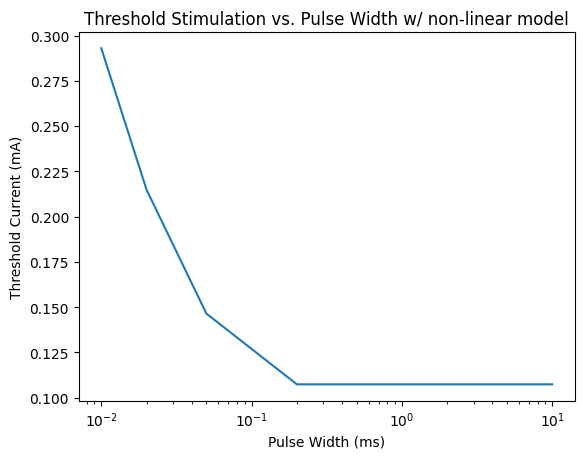

In [277]:
plt.xscale("log")
plt.plot(PWs, np.array(threshold_current_1_1))
plt.ylabel('Threshold Current (mA)')
plt.xlabel('Pulse Width (ms)')
plt.title('Threshold Stimulation vs. Pulse Width w/ non-linear model')
plt.show()

Problem 1.2 (repeat of 1.1 but with pas instead of sweeney)

In [175]:
# import NEURON library
from neuron import h
# other imports
import matplotlib.pyplot as plt
import numpy as np


# MODEL SPECIFICATION
tstop = 20 # [ms]: simulation time
h.dt = 0.01 # [ms]: timestep

def run(D, dist, amp, pw, threshold):
    """
    D: fiber diameter, um
    dist: r (electrode-fiber distance), cm
    amp: stimulus amplitude, mA (default: -1 mA)
    pw: pulse width, ms (default: 0.1 ms)
    threshold: threshold voltage, mV (default: +20mV)
    tolerance: binary search tolerance
    """

    # cell params
    v_init = -80 # [mV]: Vm @ rest, initial condition
    n_nodes = 51 # []: (int) number of sections, make this an odd number
    inl = 100 * D # [um]: internodal length
    rhoa = 54.7 # [ohm-cm]: axoplasmic/axial resistivity
    cm = 2.5 # [uF/cm**2]
    L = 1.5 # [um]
    nseg = 1 # []: (int)
    g = 0.128 # [S/cm**2] 


    # material params
    sigma_e = 2e-3 # [S/cm]: extracellular medium resistivity == 500 ohm-cm
    # stim params
    delay = 0.5 # [ms]: start time of stim
    
    # CONSTRUCT FIBER
    nodes = [h.Section(name=f'node[{i}]') for i in range(n_nodes)]

    for node_ind, node in enumerate(nodes):
        node.nseg = nseg
        node.diam = 0.6 * D
        node.L = L
        node.Ra = rhoa*((L+inl)/L)
        node.cm = cm

        node.insert('pas')
        node.insert('extracellular')

        for seg in node:
            seg.pas.g = g
            seg.pas.e = -80
            seg.extracellular.e = 0

        if node_ind > 0:
            node.connect(nodes[node_ind-1](1)) 

    # INSTRUMENTATION - STIMULATION/RECORDING
    # make dummy object to "host" the stim
    dummy = h.Section(name='dummy')
    
    # construct stimulus
    e_stim_obj = h.IClamp(dummy(0.5))
    e_stim_obj.delay = delay
    e_stim_obj.dur = pw
    e_stim_obj.amp = amp

    # calculate extracellular potentials
    phi_e = []
    # start = -((n_nodes-1)/2)*(inl+L)
    for node_ind, node in enumerate(nodes):
        x_loc = 1e-4*(-(n_nodes-1)/2*inl + inl*node_ind) # 1e-4 [um] -> [cm]
        r = np.sqrt(x_loc**2 + dist**2) # [mm]
        phi_e.append((1/(4*sigma_e*np.pi*r)))
    h.t = 0

    # neuron vectors for recording membrane potentials
    vol_mem = [h.Vector().record(sec(0.5)._ref_v) for sec in nodes]
    tvec = h.Vector().record(h._ref_t)

    AP_counts = [] # alter later
    for sec in nodes:
        AP_count = h.APCount(sec(0.5))
        AP_count.thresh = threshold
        AP_count.record()
        AP_counts.append(AP_count)

    # RUN MODEL
    # initialize
    h.finitialize(v_init)

    # run until tstop
    while h.t < tstop:
        for node, phi in zip(nodes, phi_e):
            node(0.5).e_extracellular = phi * e_stim_obj.i
        h.fadvance()

    # print(AP_counts[10].n)
    # print(AP_counts)
    # thresh = (np.abs(amp)*mA) * (threshold / (np.max(vol_mem) - v_init))

    fired = True

    if np.max(vol_mem) >= (v_init+threshold):
    # if (AP_counts[10].n == 1) and (AP_counts[13].n == 1): #action potential propogated across all nodes
        fired = True
    else: # action potential did not propogate
        fired = False

    # return np.array(AP_counts), np.array(vol_mem), np.array(tvec)
    return fired, np.array(vol_mem), np.array(tvec)

In [176]:
threshold_current = []
D = 12 # um
dist = 0.1 # cm
PWs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10] #ms
for PW in PWs:
    print("PW = {}".format(PW))
    #binary search bounds
    I_1 = 0 # mA
    I_2 = 2 # mA
    tolerance = 0.1 # %

    I_3 = 0

    while ((I_2-I_1)/I_2) > (tolerance):
        I_3 = (I_1 + I_2)/2
        amp = I_3

        fired, vol_mem, tvec = run(D=D, dist=dist, amp=-I_3, pw=PW, threshold=20)

        print(fired)

        if fired: #action potential propogated across all nodes
            I_2 = I_3
            print("I_3 updated {}".format(I_2))
        else: # action potential did not propogate
            I_1 = I_3
            print("I_3 updated {}".format(I_1))

    threshold_current.append(I_3)

print(threshold_current)

PW = 0.01
True
I_3 updated 1.0
True
I_3 updated 0.5
False
I_3 updated 0.25
True
I_3 updated 0.375
True
I_3 updated 0.3125
True
I_3 updated 0.28125
False
I_3 updated 0.265625
PW = 0.02
True
I_3 updated 1.0
True
I_3 updated 0.5
True
I_3 updated 0.25
False
I_3 updated 0.125
False
I_3 updated 0.1875
True
I_3 updated 0.21875
True
I_3 updated 0.203125
PW = 0.05
True
I_3 updated 1.0
True
I_3 updated 0.5
True
I_3 updated 0.25
False
I_3 updated 0.125
True
I_3 updated 0.1875
False
I_3 updated 0.15625
True
I_3 updated 0.171875
PW = 0.1
True
I_3 updated 1.0
True
I_3 updated 0.5
True
I_3 updated 0.25
False
I_3 updated 0.125
True
I_3 updated 0.1875
False
I_3 updated 0.15625
True
I_3 updated 0.171875
PW = 0.2
True
I_3 updated 1.0
True
I_3 updated 0.5
True
I_3 updated 0.25
False
I_3 updated 0.125
True
I_3 updated 0.1875
False
I_3 updated 0.15625
True
I_3 updated 0.171875
PW = 0.5
True
I_3 updated 1.0
True
I_3 updated 0.5
True
I_3 updated 0.25
False
I_3 updated 0.125
True
I_3 updated 0.1875
False
I_3 u

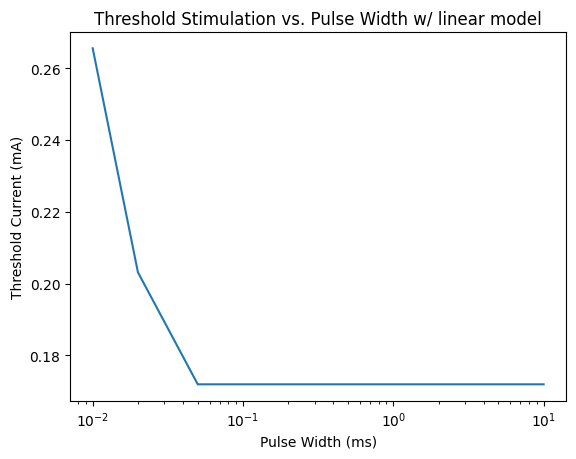

In [179]:
plt.xscale("log")
plt.plot(PWs, np.array(threshold_current))
plt.ylabel('Threshold Current (mA)')
plt.xlabel('Pulse Width (ms)')
plt.title('Threshold Stimulation vs. Pulse Width w/ linear model')
plt.show()

The strength duration curve of the linear model shares the same general shape 
as the stregth duration curve created using the non-linear model in the 
previous problem; however, there is the curve of the linear model is noticeable steeper.

Problem 1.3: (anodic)

In [370]:
# import NEURON library
from neuron import h
# other imports
import matplotlib.pyplot as plt
import numpy as np


# MODEL SPECIFICATION
tstop = 20 # [ms]: simulation time
h.dt = 0.01 # [ms]: timestep

def run(D, dist, amp, pw, threshold):
    """
    D: fiber diameter, um
    dist: r (electrode-fiber distance), cm
    amp: stimulus amplitude, mA (default: -1 mA)
    pw: pulse width, ms (default: 0.1 ms)
    threshold: threshold voltage, mV (default: +20mV)
    tolerance: binary search tolerance
    """

    # cell params
    v_init = -80 # [mV]: Vm @ rest, initial condition
    n_nodes = 51 # []: (int) number of sections, make this an odd number
    inl = 100 * D # [um]: internodal length
    rhoa = 54.7 # [ohm-cm]: axoplasmic/axial resistivity
    cm = 2.5 # [uF/cm**2]
    L = 1.5 # [um]
    nseg = 1 # []: (int)

    # material params
    sigma_e = 2e-3 # [S/cm]: extracellular medium resistivity == 500 ohm-cm
    # stim params
    delay = 5 # [ms]: start time of stim
    
    # CONSTRUCT FIBER
    nodes = [h.Section(name=f'node[{i}]') for i in range(n_nodes)]

    for node_ind, node in enumerate(nodes):
        node.nseg = nseg
        node.diam = 0.6 * D
        node.L = L
        node.Ra = rhoa*((L+inl)/L)
        node.cm = cm

        node.insert('sweeney')
        node.insert('extracellular')

        for seg in node:
            seg.extracellular.e = 0

        if node_ind > 0:
            node.connect(nodes[node_ind-1](1)) 

    # INSTRUMENTATION - STIMULATION/RECORDING
    # make dummy object to "host" the stim
    dummy = h.Section(name='dummy')
    
    # construct stimulus
    e_stim_obj = h.IClamp(dummy(0.5))
    e_stim_obj.delay = delay
    e_stim_obj.dur = pw
    e_stim_obj.amp = amp

    # calculate extracellular potentials
    phi_e = []
    # start = -((n_nodes-1)/2)*(inl+L)
    for node_ind, node in enumerate(nodes):
        x_loc = 1e-4*(-(n_nodes-1)/2*inl + inl*node_ind) # 1e-4 [um] -> [cm]
        r = np.sqrt(x_loc**2 + dist**2) # [mm]
        phi_e.append((1/(4*sigma_e*np.pi*r)))
    h.t = 0

    # neuron vectors for recording membrane potentials
    vol_mem = [h.Vector().record(sec(0.5)._ref_v) for sec in nodes]
    tvec = h.Vector().record(h._ref_t)


    # RUN MODEL
    # initialize
    h.finitialize(v_init)

    # run until tstop
    while h.t < tstop:
        for node, phi in zip(nodes, phi_e):
            node(0.5).e_extracellular = phi * e_stim_obj.i
        h.fadvance()


    fired = True

    if np.max(vol_mem) >= (v_init+threshold):
        fired = True
    else: # action potential did not propogate
        fired = False

    # return np.array(AP_counts), np.array(vol_mem), np.array(tvec)
    return fired, np.array(vol_mem), np.array(tvec)

In [358]:
threshold_current_1_3_1 = []
D = 12 # um
dist = 0.1 # cm
PWs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10] # ms
for PW in PWs:
    #binary search bounds
    I_1 = 0 # mA
    I_2 = 2.5 # mA
    tolerance = 0.1 # %

    I_3 = 0

    while ((I_2-I_1)/I_2) > (tolerance):
        I_3 = (I_1 + I_2)/2
        amp = I_3

        fired, vol_mem_anodic, tvec = run(D=D, dist=dist, amp=I_3, pw=PW, threshold=20)

        if fired: #action potential propogated across all nodes
            I_2 = I_3
        else: # action potential did not propogate
            I_1 = I_3

    threshold_current_1_3_1.append(I_3)
    print("For a PW of {} ms, the threshold is {} mA".format(PW, I_3))

print(threshold_current_1_3_1)

For a PW of 0.01 ms, the threshold is 1.328125 mA
For a PW of 0.02 ms, the threshold is 1.015625 mA
For a PW of 0.05 ms, the threshold is 0.703125 mA
For a PW of 0.1 ms, the threshold is 0.6640625 mA
For a PW of 0.2 ms, the threshold is 0.5859375 mA
For a PW of 0.5 ms, the threshold is 0.5859375 mA
For a PW of 1 ms, the threshold is 0.5859375 mA
For a PW of 2 ms, the threshold is 0.5859375 mA
For a PW of 5 ms, the threshold is 0.5859375 mA
For a PW of 10 ms, the threshold is 0.5859375 mA
[1.328125, 1.015625, 0.703125, 0.6640625, 0.5859375, 0.5859375, 0.5859375, 0.5859375, 0.5859375, 0.5859375]


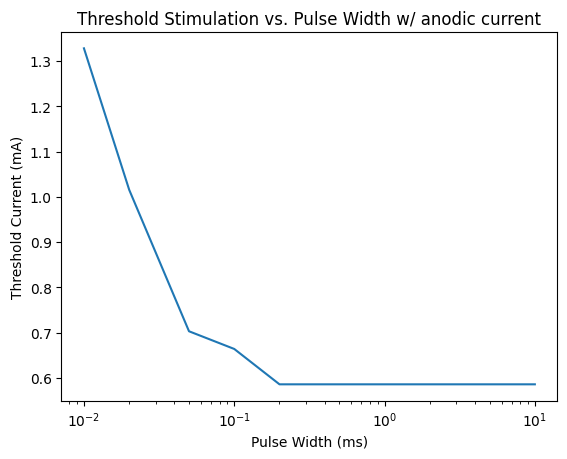

In [359]:
plt.xscale("log")
plt.plot(PWs, np.array(threshold_current_1_3_1))
plt.ylabel('Threshold Current (mA)')
plt.xlabel('Pulse Width (ms)')
plt.title('Threshold Stimulation vs. Pulse Width w/ anodic current')
plt.show()

Determine and compare action potential initiation relative to the center 
node with a threshold just above activation (for cathodic and anodic stimulation)
PW = 200 us

For a PW of 0.2 ms, the threshold is 0.5859375 mA mA (anodic)
For a PW of 0.2 ms, the threshold is 0.107421875 mA (cathodic)

In [383]:
threshold_current = []
D = 12 # um
dist = 0.1 # cm
PW = 0.2 # ms
cath_amp = 0.2 # mA
an_amp = 0.9 # mA

fired, vol_mem_anodic, tvec = run(D=D, dist=dist, amp=an_amp, pw=PW, threshold=23)
fired, vol_mem_cathodic, tvec = run(D=D, dist=dist, amp=-cath_amp, pw=PW, threshold=23)

In [384]:
spike_detected_cathodic = []
threshold = 20
for i_node, node in enumerate(np.array(vol_mem_cathodic)):
    for i_t, t in enumerate(tvec):
        if node[i_t] >= threshold:
            spike_detected_cathodic.append((i_node, i_t))

sorted_array_cathodic = sorted(spike_detected_cathodic, key=lambda x: x[1])

print(sorted_array_cathodic)

[(25, 510), (25, 511), (25, 512), (25, 513), (25, 514), (25, 515), (25, 516), (2, 558), (48, 558), (1, 559), (49, 559), (0, 560), (1, 560), (49, 560), (50, 560), (0, 561), (50, 561), (0, 562), (50, 562)]


The node at which threshold was reached for a given time array index was stored in a tuple.
This tuple was then sorted, with the first tuple representing the first node to fire.

As seen above for the cathodic case, this node was the middle node, 25.
This is expected as depolarization is maximized about the center of the stimulation waveform for cathodic stimulation.

In [377]:

spike_detected_anodic = []
threshold = 20
for i_node, node in enumerate(np.array(vol_mem_anodic)):
    for i_t, t in enumerate(tvec):
        if node[i_t] >= threshold:
            spike_detected_anodic.append((i_node, i_t))

sorted_array_anodic = sorted(spike_detected_anodic, key=lambda x: x[1])

print(sorted_array_anodic)

[(22, 510), (28, 510), (22, 511), (28, 511), (21, 512), (22, 512), (28, 512), (29, 512), (21, 513), (29, 513), (20, 514), (30, 514), (25, 525), (25, 526), (25, 527), (1, 551), (49, 551), (0, 552), (1, 552), (49, 552), (50, 552), (0, 553), (50, 553), (0, 554), (50, 554)]


The same was performed for the anodic case, with nodes 22 and 28, symmetric about the middle node, being the first nodes to fire in response to anodic stimulation.
This is expected for anodic stimulation, as the center of the stimulation waveform hyperpolarizes the fiber, while the surrounding portions serve to provide depolarization. 

Problem 1.4

In [292]:
# import NEURON library
from neuron import h
# other imports
import matplotlib.pyplot as plt
import numpy as np


# MODEL SPECIFICATION
tstop = 20 # [ms]: simulation time
h.dt = 0.01 # [ms]: timestep

def run(D, dist, amp, pw, threshold):
    """
    D: fiber diameter, um
    dist: r (electrode-fiber distance), cm
    amp: stimulus amplitude, mA (default: -1 mA)
    pw: pulse width, ms (default: 0.1 ms)
    threshold: threshold voltage, mV (default: +20mV)
    tolerance: binary search tolerance
    """

    # cell params
    v_init = -80 # [mV]: Vm @ rest, initial condition
    n_nodes = 51 # []: (int) number of sections, make this an odd number
    inl = 100 * D # [um]: internodal length
    rhoa = 54.7 # [ohm-cm]: axoplasmic/axial resistivity
    cm = 2.5 # [uF/cm**2]
    L = 1.5 # [um]
    nseg = 1 # []: (int)

    # material params
    sigma_e = 2e-3 # [S/cm]: extracellular medium resistivity == 500 ohm-cm
    # stim params
    delay = 5 # [ms]: start time of stim
    
    # CONSTRUCT FIBER
    nodes = [h.Section(name=f'node[{i}]') for i in range(n_nodes)]

    for node_ind, node in enumerate(nodes):
        node.nseg = nseg
        node.diam = 0.6 * D
        node.L = L
        node.Ra = rhoa*((L+inl)/L)
        node.cm = cm

        node.insert('sweeney')
        node.insert('extracellular')

        for seg in node:
            seg.extracellular.e = 0

        if node_ind > 0:
            node.connect(nodes[node_ind-1](1)) 

    # INSTRUMENTATION - STIMULATION/RECORDING
    # make dummy object to "host" the stim
    dummy = h.Section(name='dummy')
    
    # construct stimulus
    e_stim_obj1 = h.IClamp(dummy(0.5))
    e_stim_obj1.delay = delay
    e_stim_obj1.dur = pw
    e_stim_obj1.amp = -amp

    e_stim_obj2 = h.IClamp(dummy(0.5))
    e_stim_obj2.delay = delay+pw
    e_stim_obj2.dur = pw
    e_stim_obj2.amp = amp

    # calculate extracellular potentials
    phi_e = []
    # start = -((n_nodes-1)/2)*(inl+L)
    for node_ind, node in enumerate(nodes):
        x_loc = 1e-4*(-(n_nodes-1)/2*inl + inl*node_ind) # 1e-4 [um] -> [cm]
        r = np.sqrt(x_loc**2 + dist**2) # [mm]
        phi_e.append((1/(4*sigma_e*np.pi*r)))
    h.t = 0

    # neuron vectors for recording membrane potentials
    vol_mem = [h.Vector().record(sec(0.5)._ref_v) for sec in nodes]
    tvec = h.Vector().record(h._ref_t)


    # RUN MODEL
    # initialize
    h.finitialize(v_init)

    # run until tstop
    while h.t < tstop:
        for node, phi in zip(nodes, phi_e):
            node(0.5).e_extracellular = phi * (e_stim_obj1.i + e_stim_obj2.i)
        h.fadvance()


    fired = True

    if np.max(vol_mem) >= (v_init+threshold):
        fired = True
    else: # action potential did not propogate
        fired = False

    # return np.array(AP_counts), np.array(vol_mem), np.array(tvec)
    return fired, np.array(vol_mem), np.array(tvec)

In [296]:
threshold_current_1_4 = []
D = 12 # um
dist = 0.1 # cm
PWs = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10] #ms
for PW in PWs:
    #binary search bounds
    I_1 = 0 # mA
    I_2 = 2.5 # mA
    tolerance = 0.1 # %

    I_3 = 0

    while ((I_2-I_1)/I_2) > (tolerance):
        I_3 = (I_1 + I_2)/2
        amp = I_3

        fired, vol_mem, tvec = run(D=D, dist=dist, amp=-I_3, pw=PW, threshold=20)

        if fired: #action potential propogated across all nodes
            I_2 = I_3
        else: # action potential did not propogate
            I_1 = I_3

    threshold_current_1_4.append(I_3)
    print("For a PW of {} ms, the threshold is {} mA".format(PW, I_3))

print(threshold_current_1_4)

For a PW of 0.01 ms, the threshold is 0.4296875 mA
For a PW of 0.02 ms, the threshold is 0.25390625 mA
For a PW of 0.05 ms, the threshold is 0.146484375 mA
For a PW of 0.1 ms, the threshold is 0.126953125 mA
For a PW of 0.2 ms, the threshold is 0.107421875 mA
For a PW of 0.5 ms, the threshold is 0.107421875 mA
For a PW of 1 ms, the threshold is 0.107421875 mA
For a PW of 2 ms, the threshold is 0.107421875 mA
For a PW of 5 ms, the threshold is 0.107421875 mA
For a PW of 10 ms, the threshold is 0.107421875 mA
[0.4296875, 0.25390625, 0.146484375, 0.126953125, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.107421875]


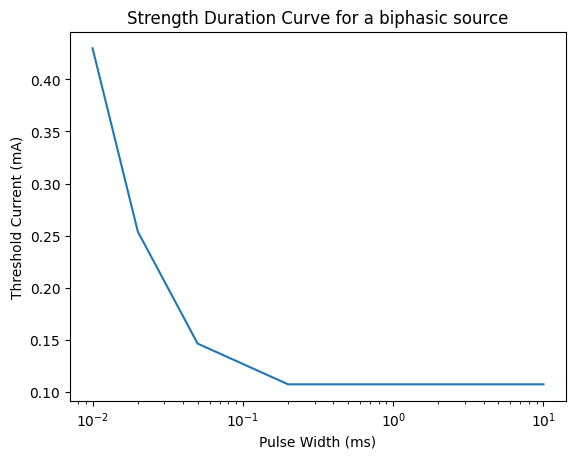

In [298]:
plt.xscale("log")
plt.plot(PWs, threshold_current_1_4, label='biphasic')
plt.ylabel('Threshold Current (mA)')
plt.xlabel('Pulse Width (ms)')
plt.title('Strength Duration Curve for a biphasic source')
plt.show()

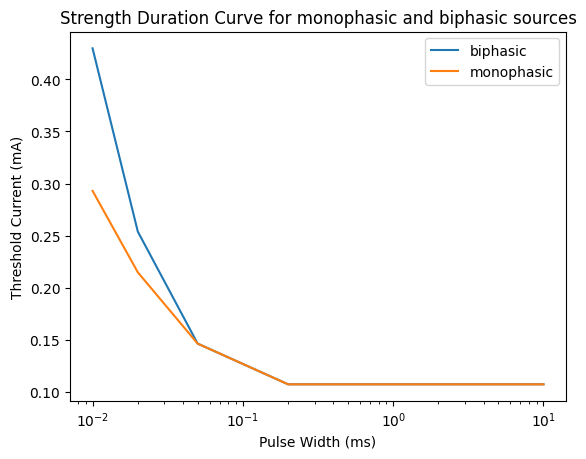

In [297]:
plt.xscale("log")
plt.plot(PWs, threshold_current_1_4, label='biphasic')
plt.plot(PWs, np.array(threshold_current_1_1), label='monophasic')
plt.ylabel('Threshold Current (mA)')
plt.xlabel('Pulse Width (ms)')
plt.title('Strength Duration Curve for monophasic and biphasic sources')
plt.legend()
plt.show()

As seen above, the biphasic configuration seems to require more current to excite the fiber at lower pulse widths,
with performance being essentially the same at larger pulse widths.

It makes sense that a monophasic source would require less excitation, as the current is only flowing inward,
whereas the biphasic source features an anodic phase in which current flows out of the nerve, potentially
reducing the overall amount of charge within the fiber, thus making depolarization more difficult.

Problem 1.5

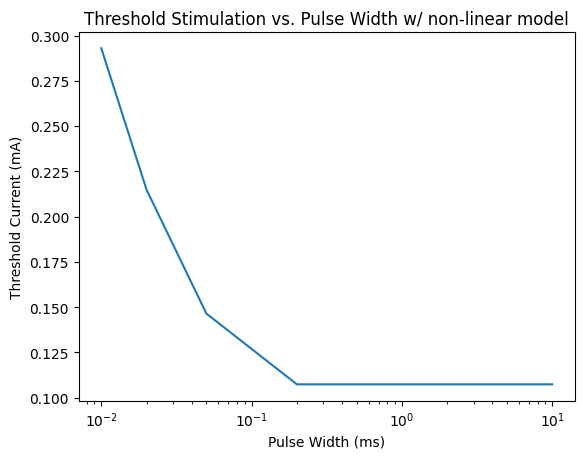

[0.29296875, 0.21484375, 0.146484375, 0.126953125, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.107421875, 0.107421875]


In [278]:
plt.xscale("log")
plt.plot(PWs, np.array(threshold_current_1_1))
plt.ylabel('Threshold Current (mA)')
plt.xlabel('Pulse Width (ms)')
plt.title('Threshold Stimulation vs. Pulse Width w/ non-linear model')
plt.show()
print(threshold_current_1_1)

From the above plot and data from problem 1.1, it can be clearly seen through visual inspection that the rheobase is equal to 0.107421875,
as this is the lowest value on the curve and demonstrates steady-state characteristics.

The chronaxie can be determined by looking at the pulse width value at twice the rheobase, which is luckily present in the second value of
the above plot at 20 microseconds.

With both the rheobase and chronaxie, the Weiss form of the strength duration curve can be used to fit the data:

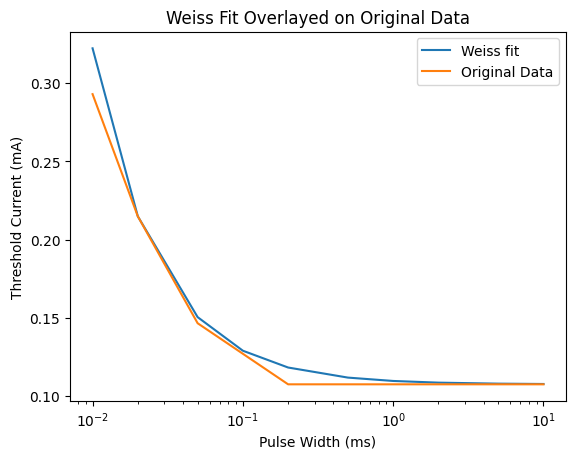

In [279]:
r_base = 0.107421875 # mA
chronaxie = 0.02 # ms

#calculation of weiss fit:
I_th = np.zeros(len(PWs))
for i, PW in enumerate(PWs):
    I_th[i] = r_base*(1 + (chronaxie/PW))

# overlay of fit

plt.xscale("log")
plt.plot(PWs, I_th, label='Weiss fit')
plt.plot(PWs, np.array(threshold_current_1_1), label='Original Data')
plt.legend()
plt.ylabel('Threshold Current (mA)')
plt.xlabel('Pulse Width (ms)')
plt.title('Weiss Fit Overlayed on Original Data')
plt.legend()
plt.show()

As seen above, the Weiss fit provides a great fit for the data, at least qualitatively. Next, the percent residuals of
the fit were calculated and plotted:

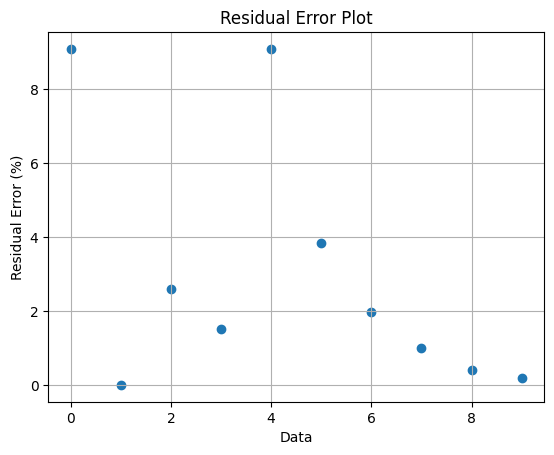

In [287]:
weiss = np.array(I_th)

percent_residuals = ((weiss - threshold_current_1_1) / weiss) * 100


plt.scatter(range(PW),percent_residuals)
plt.xlabel('Data')
plt.ylabel('Residual Error (%)')
plt.title('Residual Error Plot')
plt.grid(True)
plt.show()

Problem 2

As seen Havton et al. 2021 in Figure 1F, the largest reported fiber diameter in the Vagus nerve is
8.5 um within the cervical section of the nerve.

In [301]:
# import NEURON library
from neuron import h
# other imports
import matplotlib.pyplot as plt
import numpy as np


# MODEL SPECIFICATION
tstop = 20 # [ms]: simulation time
h.dt = 0.01 # [ms]: timestep

def compute_sin(amp, frequency, t):
    return amp * np.sin(2 * np.pi * frequency * t)


def run(D, dist, amp, pw, threshold):
    # cell params
    v_init = -80 # [mV]: Vm @ rest, initial condition
    n_nodes = 51 # []: (int) number of sections, make this an odd number
    inl = 100 * D # [um]: internodal length
    rhoa = 54.7 # [ohm-cm]: axoplasmic/axial resistivity
    cm = 2.5 # [uF/cm**2]
    L = 1.5 # [um]
    nseg = 1 # []: (int)

    # material params
    sigma_e = 2e-3 # [S/cm]: extracellular medium resistivity == 500 ohm-cm
    # stim params
    delay = 5 # [ms]: start time of stim
    frequency = 25 # Hz

    # CONSTRUCT FIBER
    nodes = [h.Section(name=f'node[{i}]') for i in range(n_nodes)]

    for node_ind, node in enumerate(nodes):
        node.nseg = nseg
        node.diam = 0.6 * D
        node.L = L
        node.Ra = rhoa*((L+inl)/L)
        node.cm = cm

        node.insert('sweeney')
        node.insert('extracellular')

        for seg in node:
            seg.extracellular.e = 0

        if node_ind > 0:
            node.connect(nodes[node_ind-1](1)) 

    # INSTRUMENTATION - STIMULATION/RECORDING
    # make dummy object to "host" the stim
    dummy = h.Section(name='dummy')
    
    # construct bipolar stimulus
    e_stim_obj1 = h.IClamp(dummy(0.5))
    e_stim_obj1.delay = delay
    e_stim_obj1.dur = pw
    e_stim_obj1.amp = amp

    e_stim_obj2 = h.IClamp(dummy(0.5))
    e_stim_obj2.delay = delay
    e_stim_obj2.dur = pw
    e_stim_obj2.amp = -amp

    # calculate extracellular potentials
    phi_e1 = []
    phi_e2 = []
    # start = -((n_nodes-1)/2)*(inl+L)
    for node_ind, node in enumerate(nodes):
        x_loc = 1e-4*(-(n_nodes-1)/2*inl + inl*node_ind) # 1e-4 [um] -> [cm]
        r1 = np.sqrt((5+x_loc)**2 + dist**2) # [mm] account for 5 cm distance between electrodes
        r2 = np.sqrt((x_loc)**2 + dist**2) # [mm]
        phi_e1.append((1/(4*sigma_e*np.pi*r1)))
        phi_e2.append((1/(4*sigma_e*np.pi*r2)))
    h.t = 0

    # neuron vectors for recording membrane potentials
    vol_mem = [h.Vector().record(sec(0.5)._ref_v) for sec in nodes]
    tvec = h.Vector().record(h._ref_t)


    # RUN MODEL
    # initialize
    h.finitialize(v_init)

    # run until tstop
    while h.t < tstop:
        for node, phi1, phi2 in zip(nodes, phi_e1, phi_e2):
            e_stim_obj1.amp = compute_sin(amp, frequency, h.t)
            e_stim_obj2.amp = -1*compute_sin(amp, frequency, h.t)
            node(0.5).e_extracellular = phi1 * (e_stim_obj1.i) + phi2 * (e_stim_obj2.i)
        h.fadvance()

    fired = True

    if np.max(vol_mem) >= (v_init+threshold):
        fired = True
    else: # action potential did not propogate
        fired = False

    # return np.array(AP_counts), np.array(vol_mem), np.array(tvec)
    return fired, np.array(vol_mem), np.array(tvec)

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h

threshold_current_2_1 = []
D = 8.5 # um
dist = 3 # cm
PW = 40 #ms

#binary search bounds
I_1 = 0 # mA
I_2 = 2000 # mA
tolerance = 0.1 # %

I_3 = 0

while ((I_2-I_1)/I_2) > (tolerance):
    I_3 = (I_1 + I_2)/2
    amp = I_3

    fired, vol_mem, tvec = run(D=D, dist=dist, amp=-I_3, pw=PW, threshold=20)

    if fired: #action potential propogated across all nodes
        I_2 = I_3
    else: # action potential did not propogate
        I_1 = I_3
        print(I_3)
    print(fired)
threshold_current_2_1.append(I_3)
print("For a PW of {} ms, the threshold is {} mA".format(PW, I_3))

print(threshold_current_2_1)


True
True
True
125.0
False
187.5
False
True
True
For a PW of 40 ms, the threshold is 203.125 mA
[203.125]


Using the specified stimulation settings of a bipolar stimulus 3 cm away from the nerve, electrode contacts 5 cm apart,
and an output of a 25 Hz sin wave, a binary search was conducted with 60 mA as an upper bound in order to represent the
maximum output of the device. A pulse width of 40 ms was selected.

The binary search returned an amplitude of 203.125 mA, meaning that the device was unable to activate the largest diameter
vagus nerve fiber reported in Havton et al. 2021 (8.5 um) within the given current specification.
Given that the majority of vagus nerve fibers are significantly smaller than this, with most being ~1.75 um, it will
be incredibly difficult to acheive any meaningful stimulation within the nerve.

Problem 2.2

In order to increase the amount of nerve activation without changing the maximum current output of the device,
the pulse width may be increased, as additional charge would be delivered to the nerve fibers, providing for 
increased recruitment. Otherwise, the device could be physcially redesiged such that the electrode contacts
are closer to the nerve of interest.

Problem 2.3

One limitation with the modeling used in this analysis include a lack of realistic geometry
for the nerve and electrodes. This model also fails to consider fasicular organization of fibers, or
the activation of neighboring fibers of varying diameters, as ephaptic coupling may occur and affect the overall fiber activation. 
These issues could be circumvented using a finite element modeling program such as COMSOL to create 
3D models from the electrode geometry and realistic nerve geometry in order to calculate a potential
distribution that would provide a clearer analysis, allowing for a more measured evalutaion of the device.
